In [12]:
import pandas as pd
import numpy as np
import yfinance as yf

In [13]:
df = pd.read_csv('/Users/shubhamsharma/Desktop/snp_beta_macd_signal_rsi.csv')
df.head()

,Stock,5/1/14 0:00,5/2/14 0:00,5/5/14 0:00,5/6/14 0:00,5/7/14 0:00,5/8/14 0:00,5/9/14 0:00,5/12/14 0:00,5/13/14 0:00,...,4/24/24 0:00,4/25/24 0:00,4/26/24 0:00,4/29/24 0:00,4/30/24 0:00,Industry,Beta,MACD,Signal,RSI
0,A,35.818909,35.864948,36.384441,36.174015,36.187160,36.364704,36.423893,37.094631,37.370804,...,137.490005,136.369995,137.740005,139.589996,137.039993,Diagnostics & Research,1.126,-1.536634,-1.509291,45.444335
1,AAL,34.306366,34.400639,34.504337,34.570320,35.088844,36.059853,36.069294,37.134579,37.059177,...,13.920000,14.130000,13.880000,13.980000,13.510000,Airlines,1.580,-0.129848,-0.153215,39.044930
2,AAPL,18.581390,18.615952,18.879210,18.673439,18.608089,18.574923,18.497526,18.727819,18.757200,...,168.791061,169.659882,169.070679,173.264984,170.099289,Consumer Electronics,1.264,-0.861375,-1.433049,52.048345
3,ABBV,34.194000,33.909100,34.028362,33.730228,34.975811,34.551777,34.624657,34.697540,34.584908,...,167.800003,167.289993,159.619995,161.520004,162.639999,Drug Manufacturers - General,0.593,-2.645659,-2.440588,39.560258
4,ABNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,162.839996,163.009995,164.229996,162.250000,158.570007,Travel Services,1.246,0.133508,0.029556,43.219668


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import cvxpy as cp



# Preprocess data
df.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
df[['Beta', 'RSI', 'MACD', 'Signal']] = scaler.fit_transform(df[['Beta', 'RSI', 'MACD', 'Signal']])

# Classify stocks by risk level
def classify_risk(beta):
    if beta < 0.8:
        return 'Low Risk'
    elif beta < 1.2:
        return 'Balanced'
    else:
        return 'High Risk'

df['Risk_Category'] = df['Beta'].apply(classify_risk)

# Select 5 stocks for the portfolio
low_risk_stocks = df[df['Risk_Category'] == 'Low Risk'].head(2)
balanced_stocks = df[df['Risk_Category'] == 'Balanced'].head(2)
high_risk_stocks = df[df['Risk_Category'] == 'High Risk'].head(1)

selected_stocks = pd.concat([low_risk_stocks, balanced_stocks, high_risk_stocks])

# Extract stock prices data for selected stocks only
stock_prices = df[df['Stock'].isin(selected_stocks['Stock'])].filter(like='20', axis=1).T

# Ensure the data is in the correct shape
stock_prices.columns = stock_prices.iloc[0]
stock_prices = stock_prices.drop(stock_prices.index[0])

# Convert all data to float
stock_prices = stock_prices.astype(float)

# Calculate expected returns and covariance matrix
mu = expected_returns.mean_historical_return(stock_prices)
S = risk_models.sample_cov(stock_prices)

# Optimize portfolio
ef = EfficientFrontier(mu, S)

try:
    weights = ef.max_sharpe()
except (cp.DCPError, cp.SolverError) as e:
    print(f"Optimization error: {e}")
    print("Trying a different solver...")
    ef = EfficientFrontier(mu, S, solver="SCS")
    weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
print(cleaned_weights)

# Portfolio performance
ef.portfolio_performance(verbose=True)

# Discrete allocation
latest_prices = get_latest_prices(stock_prices)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=100000)
allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining:', leftover)


OrderedDict([(35.71368789672852, 1.0), (36.05043411254883, 0.0), (73.29563141, 0.0), (80.22460174560547, 0.0)])
Expected annual return: 181.8%
Annual volatility: 66.4%
Sharpe Ratio: 2.71
Discrete allocation: {35.71368789672852: 680}
Funds remaining: 12.03660003755067


/var/folders/y2/0dh3c4pd4xbdbvkz74q2jh080000gn/T/ipykernel_81030/865198370.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import cvxpy as cp

# For reproducibility
np.random.seed(42)



# Preprocess data
df.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
df[['Beta', 'RSI', 'MACD', 'Signal']] = scaler.fit_transform(df[['Beta', 'RSI', 'MACD', 'Signal']])

# Define weights
weights = {
    'Beta': 0.4,
    'RSI': 0.3,
    'MACD': 0.2,
    'Signal': 0.1
}

# Calculate weighted score for each stock
df['Weighted_Score'] = (weights['Beta'] * df['Beta'] +
                        weights['RSI'] * df['RSI'] +
                        weights['MACD'] * df['MACD'] +
                        weights['Signal'] * df['Signal'])

# Sort stocks by weighted score
df = df.sort_values(by='Weighted_Score', ascending=False)

# Extract stock prices data for selected stocks only
price_columns = [col for col in df.columns if '20' in col]
stock_prices = df.set_index('Stock')[price_columns].T

# Convert all data to float
stock_prices = stock_prices.astype(float)

# Calculate expected returns and covariance matrix
mu = expected_returns.mean_historical_return(stock_prices)
S = risk_models.sample_cov(stock_prices)

# Filter stocks with positive expected returns
positive_mu_stocks = mu[mu > 0].index.tolist()
df = df[df['Stock'].isin(positive_mu_stocks)]

# Select top 5 stocks based on weighted score
selected_stocks = df.head(5)
selected_stock_prices = stock_prices[selected_stocks['Stock']]

# Recalculate expected returns and covariance matrix for selected stocks
mu_selected = mu[selected_stocks['Stock']]
S_selected = S.loc[selected_stocks['Stock'], selected_stocks['Stock']]

# Optimize portfolio
ef = EfficientFrontier(mu_selected, S_selected)

try:
    # Set a lower risk-free rate
    weights = ef.max_sharpe(risk_free_rate=0.01)
    cleaned_weights = ef.clean_weights()
    ef.portfolio_performance(verbose=True)
    
    # Discrete allocation
    latest_prices = get_latest_prices(selected_stock_prices)
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=100000)
    allocation, leftover = da.lp_portfolio()
    print('Discrete allocation:', allocation)
    print('Funds remaining:', leftover)

    # Add stock names to the result
    allocation_df = pd.DataFrame(list(allocation.items()), columns=['Stock', 'Shares'])
    allocation_df = allocation_df.merge(df[['Stock', 'Industry']], on='Stock', how='left')
    print(allocation_df)

except (ValueError, cp.DCPError, cp.SolverError) as e:
    print(f"Optimization error: {e}")


Expected annual return: 452.1%
Annual volatility: 98.5%
Sharpe Ratio: 4.58
Discrete allocation: {'CMG': 10, 'TSLA': 286, 'ZBRA': 16, 'NXPI': 67}
Funds remaining: 73.18837594636716
  Stock  Shares                 Industry
0   CMG      10              Restaurants
1  TSLA     286       Auto Manufacturers
2  ZBRA      16  Communication Equipment
3  NXPI      67           Semiconductors


/var/folders/y2/0dh3c4pd4xbdbvkz74q2jh080000gn/T/ipykernel_81030/1944829863.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/opt/homebrew/lib/python3.11/site-packages/pypfopt/risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/pypfopt/risk_models.py:89: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


/var/folders/y2/0dh3c4pd4xbdbvkz74q2jh080000gn/T/ipykernel_81030/655770736.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/y2/0dh3c4pd4xbdbvkz74q2jh080000gn/T/ipykernel_81030/655770736.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


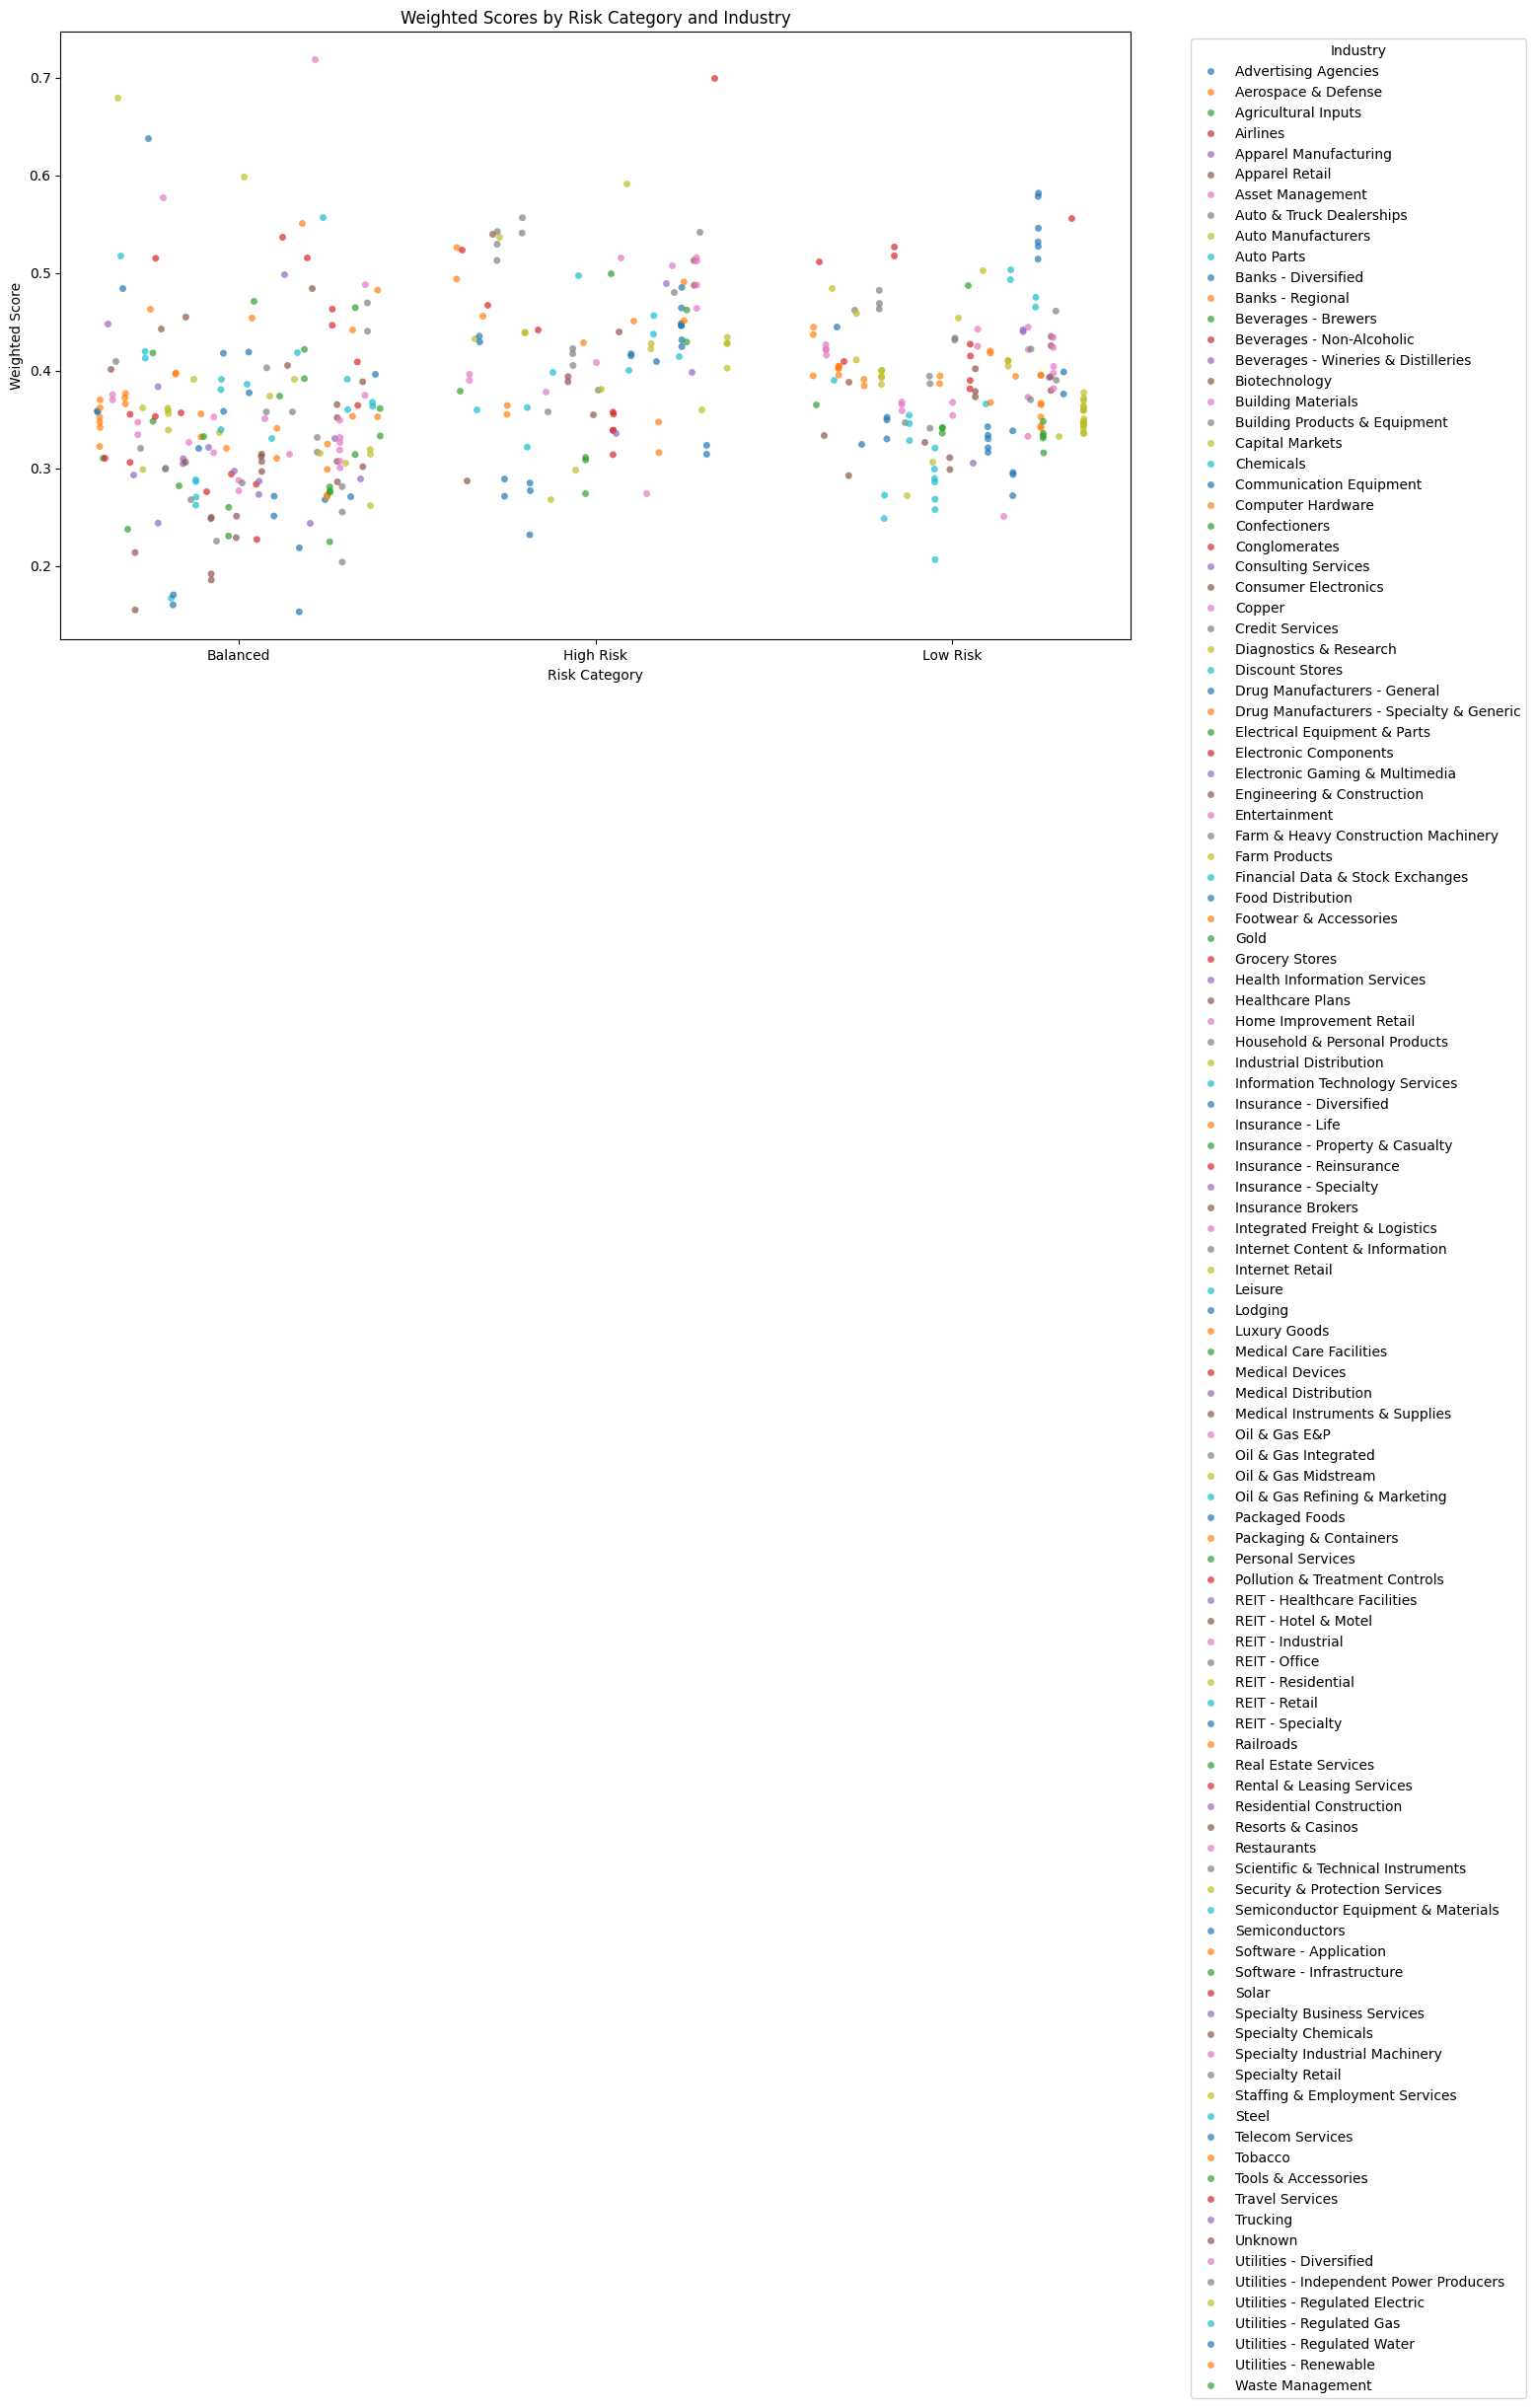

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)


# Preprocess data
df.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
df[['Beta', 'RSI', 'MACD', 'Signal']] = scaler.fit_transform(df[['Beta', 'RSI', 'MACD', 'Signal']])

# Define weights
weights = {
    'Beta': 0.4,
    'RSI': 0.3,
    'MACD': 0.2,
    'Signal': 0.1
}

# Calculate weighted score for each stock
df['Weighted_Score'] = (weights['Beta'] * df['Beta'] +
                        weights['RSI'] * df['RSI'] +
                        weights['MACD'] * df['MACD'] +
                        weights['Signal'] * df['Signal'])

# Function to perform clustering within each industry
def cluster_stocks(industry_df):
    if len(industry_df) < 3:
        # Assign to default categories based on weighted score
        industry_df['Risk_Category'] = 'Balanced'
        return industry_df
    else:
        kmeans = KMeans(n_clusters=3, random_state=42)
        industry_df['Cluster'] = kmeans.fit_predict(industry_df[['Weighted_Score']])
        
        # Assign cluster labels as 'Low Risk', 'Balanced', 'High Risk'
        cluster_labels = {0: 'Low Risk', 1: 'Balanced', 2: 'High Risk'}
        industry_df['Risk_Category'] = industry_df['Cluster'].map(cluster_labels)
        
        return industry_df

# Apply clustering to each industry
clustered_dfs = []
for industry, industry_df in df.groupby('Industry'):
    clustered_dfs.append(cluster_stocks(industry_df.copy()))

# Combine all the clustered dataframes
clustered_df = pd.concat(clustered_dfs)

# Visualization: Strip plot with different risk categories, weighted scores, and industries
plt.figure(figsize=(14, 8))

sns.stripplot(
    data=clustered_df,
    x='Risk_Category', y='Weighted_Score',
    hue='Industry', dodge=True,
    jitter=True, alpha=0.7, palette='tab10'
)

plt.title('Weighted Scores by Risk Category and Industry')
plt.xlabel('Risk Category')
plt.ylabel('Weighted Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Industry')
plt.tight_layout()
plt.show()


In [17]:
clustered_df

,Stock,5/1/14 0:00,5/2/14 0:00,5/5/14 0:00,5/6/14 0:00,5/7/14 0:00,5/8/14 0:00,5/9/14 0:00,5/12/14 0:00,5/13/14 0:00,...,4/29/24 0:00,4/30/24 0:00,Industry,Beta,MACD,Signal,RSI,Risk_Category,Weighted_Score,Cluster
354,OMC,48.282078,48.318092,48.037182,47.626598,47.381706,47.684227,48.735867,49.362522,49.535408,...,95.889999,92.839996,Advertising Agencies,0.351993,0.360029,0.361641,0.365987,Balanced,0.358763,NaN
248,IPG,12.303831,12.346404,12.360597,12.403169,12.410266,12.381882,12.658613,12.708280,12.729572,...,31.430000,30.440001,Advertising Agencies,0.417727,0.352690,0.352449,0.282898,Balanced,0.357743,NaN
433,TDG,109.936661,110.379379,112.660637,109.844421,110.041191,111.473869,110.680687,110.324028,112.974228,...,1258.719971,1248.030029,Aerospace & Defense,0.532231,0.462556,0.479141,0.576127,High Risk,0.526156,2.0
200,GE,103.292542,102.945274,102.559433,101.054611,102.366508,102.019257,101.942070,103.601250,103.871338,...,164.490005,161.820007,Aerospace & Defense,0.468617,0.402831,0.421066,0.612381,High Risk,0.493834,2.0
47,AXON,15.250000,14.130000,14.410000,13.200000,13.130000,13.140000,13.260000,14.060000,13.640000,...,313.299988,313.660004,Aerospace & Defense,0.325276,0.360724,0.357492,0.688682,Low Risk,0.444609,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,AWK,37.796658,37.755764,38.074692,37.763943,38.369080,38.467865,38.080971,38.122120,38.739521,...,121.589638,121.629410,Utilities - Regulated Water,0.201442,0.359561,0.355971,0.696490,Balanced,0.397033,NaN
203,GEV,7.637840,7.717400,7.615108,7.611322,7.660570,7.626473,7.876518,8.054587,8.050796,...,159.009995,153.710007,Utilities - Renewable,0.409669,0.384915,0.368630,0.682666,Balanced,0.482513,NaN
88,CEG,49.766335,49.741936,49.928944,49.660633,49.359818,48.871986,48.392303,49.506161,48.912643,...,188.610001,185.940002,Utilities - Renewable,0.259966,0.379130,0.400962,0.442866,Balanced,0.352769,NaN
404,RSG,28.734299,28.644060,28.676874,28.652262,28.832726,28.758902,28.742502,28.873737,28.890150,...,193.410004,191.699997,Waste Management,0.227311,0.367472,0.371975,0.532066,Balanced,0.361236,NaN


In [18]:
clustered_df.to_csv('/Users/shubhamsharma/Downloads/final.csv')

In [19]:
low_risk_portfolio = clustered_df[clustered_df['Risk_Category'] == 'Low Risk']
balanced_portfolio = clustered_df[clustered_df['Risk_Category'] == 'Balanced']
high_risk_portfolio = clustered_df[clustered_df['Risk_Category'] == 'High Risk']

# Display the portfolios
print("Low Risk Portfolio:\n", low_risk_portfolio)
print("Balanced Portfolio:\n", balanced_portfolio)
print("High Risk Portfolio:\n", high_risk_portfolio)


Low Risk Portfolio:
     Stock  5/1/14 0:00  5/2/14 0:00  5/5/14 0:00  5/6/14 0:00  5/7/14 0:00  \
47   AXON    15.250000    14.130000    14.410000    13.200000    13.130000   
281   LHX    59.990612    59.900822    60.047768    60.178387    61.125443   
50     BA   110.410355   111.682381   113.418587   112.447327   112.663422   
89     CF    36.357765    36.563580    36.736374    36.586124    36.787437   
457   UAL    40.919998    40.720001    40.520000    40.090000    39.900002   
..    ...          ...          ...          ...          ...          ...   
14    AEP    37.356419    36.635235    37.002773    36.649097    37.454185   
174  EVRG    24.908924    24.443403    24.540674    24.401712    24.811649   
379   PNW    37.859570    36.553600    36.986664    37.054344    37.839268   
484   WEC    35.093716    34.254902    34.426968    34.168865    34.735241   
148   DUK    48.427448    47.310589    47.739170    47.446960    47.933952   

     5/8/14 0:00  5/9/14 0:00  5/12/14 0:0

In [20]:
clustered_df

,Stock,5/1/14 0:00,5/2/14 0:00,5/5/14 0:00,5/6/14 0:00,5/7/14 0:00,5/8/14 0:00,5/9/14 0:00,5/12/14 0:00,5/13/14 0:00,...,4/29/24 0:00,4/30/24 0:00,Industry,Beta,MACD,Signal,RSI,Risk_Category,Weighted_Score,Cluster
354,OMC,48.282078,48.318092,48.037182,47.626598,47.381706,47.684227,48.735867,49.362522,49.535408,...,95.889999,92.839996,Advertising Agencies,0.351993,0.360029,0.361641,0.365987,Balanced,0.358763,NaN
248,IPG,12.303831,12.346404,12.360597,12.403169,12.410266,12.381882,12.658613,12.708280,12.729572,...,31.430000,30.440001,Advertising Agencies,0.417727,0.352690,0.352449,0.282898,Balanced,0.357743,NaN
433,TDG,109.936661,110.379379,112.660637,109.844421,110.041191,111.473869,110.680687,110.324028,112.974228,...,1258.719971,1248.030029,Aerospace & Defense,0.532231,0.462556,0.479141,0.576127,High Risk,0.526156,2.0
200,GE,103.292542,102.945274,102.559433,101.054611,102.366508,102.019257,101.942070,103.601250,103.871338,...,164.490005,161.820007,Aerospace & Defense,0.468617,0.402831,0.421066,0.612381,High Risk,0.493834,2.0
47,AXON,15.250000,14.130000,14.410000,13.200000,13.130000,13.140000,13.260000,14.060000,13.640000,...,313.299988,313.660004,Aerospace & Defense,0.325276,0.360724,0.357492,0.688682,Low Risk,0.444609,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,AWK,37.796658,37.755764,38.074692,37.763943,38.369080,38.467865,38.080971,38.122120,38.739521,...,121.589638,121.629410,Utilities - Regulated Water,0.201442,0.359561,0.355971,0.696490,Balanced,0.397033,NaN
203,GEV,7.637840,7.717400,7.615108,7.611322,7.660570,7.626473,7.876518,8.054587,8.050796,...,159.009995,153.710007,Utilities - Renewable,0.409669,0.384915,0.368630,0.682666,Balanced,0.482513,NaN
88,CEG,49.766335,49.741936,49.928944,49.660633,49.359818,48.871986,48.392303,49.506161,48.912643,...,188.610001,185.940002,Utilities - Renewable,0.259966,0.379130,0.400962,0.442866,Balanced,0.352769,NaN
404,RSG,28.734299,28.644060,28.676874,28.652262,28.832726,28.758902,28.742502,28.873737,28.890150,...,193.410004,191.699997,Waste Management,0.227311,0.367472,0.371975,0.532066,Balanced,0.361236,NaN


In [21]:
# Function to select 5 stocks for a given risk category without exceeding the budget
def select_stocks_for_investment(df, investment_amount, num_stocks=5):
    selected_stocks = []
    available_stocks = df.sort_values(by='4/30/24 0:00')
    total_cost = 0
    
    for index, stock in available_stocks.iterrows():
        if total_cost + stock['4/30/24 0:00'] <= investment_amount:
            selected_stocks.append(stock)
            total_cost += stock['4/30/24 0:00']
            if len(selected_stocks) == num_stocks:
                break
    
    return pd.DataFrame(selected_stocks)

# Create portfolios
portfolios = []
risk_categories = ['Low Risk', 'Balanced', 'High Risk']
remaining_amount = 500

for i in range(3):
    portfolio = pd.DataFrame()
    for risk_category in risk_categories:
        selected_stocks = select_stocks_for_investment(clustered_df[clustered_df['Risk_Category'] == risk_category], remaining_amount / 3)
        portfolio = pd.concat([portfolio, selected_stocks])
        remaining_amount -= selected_stocks['4/30/24 0:00'].sum()
    portfolios.append(portfolio)

# Display the portfolios
for i, portfolio in enumerate(portfolios):
    print(f"Portfolio {i+1}:")
    print(portfolio)
    print("\n")




Portfolio 1:
    Stock  5/1/14 0:00  5/2/14 0:00  5/5/14 0:00  5/6/14 0:00  5/7/14 0:00  \
219  HBAN     6.219002     6.260099     6.239549     6.177908     6.266946   
266   KEY     9.429811     9.527387     9.527387     9.332237     9.492537   
431     T    12.708467    12.726328    12.772763    12.676325    12.772763   
269   KIM    14.329844    14.304925    14.280021    14.236425    14.448167   
395    RF     7.409471     7.431241     7.438498     7.336897     7.438498   
26   AMCR     6.322430     6.322430     6.322430     6.395713     6.395713   
15    AES    10.551307    10.264783    10.236129    10.164498    10.365066   
276  KVUE    19.076069    19.216547    19.191761    19.166969    19.150440   
232   HST    14.812651    14.791985    14.681748    14.633525    14.729979   
290   LUV    22.220034    22.083048    22.156107    22.101311    22.101311   
180     F     9.611874     9.605830     9.509168     9.400423     9.340009   
368   PFE    19.988811    19.732138    19.225193   

In [25]:
# Function to select stocks for a given risk category without exceeding the budget
def select_stocks_for_investment(df, investment_amount, num_stocks=5):
    selected_stocks = []
    available_stocks = df.sort_values(by='4/30/24 0:00')
    total_cost = 0
    
    for index, stock in available_stocks.iterrows():
        if total_cost + stock['4/30/24 0:00'] <= investment_amount:
            selected_stocks.append(stock)
            total_cost += stock['4/30/24 0:00']
            if len(selected_stocks) == num_stocks:
                break
    
    return pd.DataFrame(selected_stocks)

# Create portfolios ensuring each portfolio sums to $500 and has 5 stocks
def create_portfolios(df, investment_amount, num_stocks=5):
    portfolios = []
    portfolio_labels = ['Low Risk', 'Balanced', 'High Risk']
    for label in portfolio_labels:
        portfolio = select_stocks_for_investment(df[df['Risk_Category'] == label], investment_amount, num_stocks)
        portfolio['Portfolio_Number'] = label
        portfolios.append(portfolio)
    return pd.concat(portfolios)

# Generate portfolios
portfolios = create_portfolios(clustered_df, 500)

# Display the combined portfolios
print(portfolios)

# Save the combined portfolios to a single CSV file
portfolios.to_csv('combined_portfolios.csv', index=False)


    Stock  5/1/14 0:00  5/2/14 0:00  5/5/14 0:00  5/6/14 0:00  5/7/14 0:00  \
219  HBAN     6.219002     6.260099     6.239549     6.177908     6.266946   
266   KEY     9.429811     9.527387     9.527387     9.332237     9.492537   
431     T    12.708467    12.726328    12.772763    12.676325    12.772763   
269   KIM    14.329844    14.304925    14.280021    14.236425    14.448167   
395    RF     7.409471     7.431241     7.438498     7.336897     7.438498   
26   AMCR     6.322430     6.322430     6.322430     6.395713     6.395713   
15    AES    10.551307    10.264783    10.236129    10.164498    10.365066   
276  KVUE    19.076069    19.216547    19.191761    19.166969    19.150440   
232   HST    14.812651    14.791985    14.681748    14.633525    14.729979   
290   LUV    22.220034    22.083048    22.156107    22.101311    22.101311   
180     F     9.611874     9.605830     9.509168     9.400423     9.340009   
368   PFE    19.988811    19.732138    19.225193    18.885094   

In [26]:
# Ensure the required packages are imported
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans



# Preprocess data
df.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
df[['Beta', 'RSI', 'MACD', 'Signal']] = scaler.fit_transform(df[['Beta', 'RSI', 'MACD', 'Signal']])

# Define weights
weights = {
    'Beta': 0.4,
    'RSI': 0.3,
    'MACD': 0.2,
    'Signal': 0.1
}

# Calculate weighted score for each stock
df['Weighted_Score'] = (weights['Beta'] * df['Beta'] +
                        weights['RSI'] * df['RSI'] +
                        weights['MACD'] * df['MACD'] +
                        weights['Signal'] * df['Signal'])

# Use the specified column for 'Cost'
df['Cost'] = df['4/30/24 0:00']

# Function to perform clustering within each industry
def cluster_stocks(industry_df):
    if len(industry_df) < 3:
        industry_df['Risk_Category'] = 'Balanced'
        return industry_df
    else:
        kmeans = KMeans(n_clusters=3, random_state=42)
        industry_df['Cluster'] = kmeans.fit_predict(industry_df[['Weighted_Score']])
        cluster_labels = {0: 'Low Risk', 1: 'Balanced', 2: 'High Risk'}
        industry_df['Risk_Category'] = industry_df['Cluster'].map(cluster_labels)
        return industry_df

# Apply clustering to each industry
clustered_dfs = []
for industry, industry_df in df.groupby('Industry'):
    clustered_dfs.append(cluster_stocks(industry_df.copy()))

# Combine all the clustered dataframes
clustered_df = pd.concat(clustered_dfs)

# Function to select 5 stocks for a given risk category without exceeding the budget
def select_stocks_for_investment(df, investment_amount, num_stocks=5):
    selected_stocks = []
    available_stocks = df.sort_values(by='Cost')
    total_cost = 0
    
    for index, stock in available_stocks.iterrows():
        if total_cost + stock['Cost'] <= investment_amount:
            selected_stocks.append(stock)
            total_cost += stock['Cost']
            if len(selected_stocks) == num_stocks:
                break
    
    return pd.DataFrame(selected_stocks)

# Create portfolios ensuring each portfolio sums to $500 and has 5 stocks
def create_portfolios(df, investment_amount, num_stocks=5):
    portfolios = []
    portfolio_labels = ['Low Risk', 'Balanced', 'High Risk']
    for label in portfolio_labels:
        portfolio = select_stocks_for_investment(df[df['Risk_Category'] == label], investment_amount, num_stocks)
        portfolio['Portfolio_Number'] = label
        portfolios.append(portfolio)
    return pd.concat(portfolios)

# Generate portfolios
portfolios = create_portfolios(clustered_df, 500)

# Display the combined portfolios
print(portfolios)




/var/folders/y2/0dh3c4pd4xbdbvkz74q2jh080000gn/T/ipykernel_81030/2208664911.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


    Stock  5/1/14 0:00  5/2/14 0:00  5/5/14 0:00  5/6/14 0:00  5/7/14 0:00  \
219  HBAN     6.219002     6.260099     6.239549     6.177908     6.266946   
266   KEY     9.429811     9.527387     9.527387     9.332237     9.492537   
431     T    12.708467    12.726328    12.772763    12.676325    12.772763   
269   KIM    14.329844    14.304925    14.280021    14.236425    14.448167   
395    RF     7.409471     7.431241     7.438498     7.336897     7.438498   
26   AMCR     6.322430     6.322430     6.322430     6.395713     6.395713   
15    AES    10.551307    10.264783    10.236129    10.164498    10.365066   
276  KVUE    19.076069    19.216547    19.191761    19.166969    19.150440   
232   HST    14.812651    14.791985    14.681748    14.633525    14.729979   
290   LUV    22.220034    22.083048    22.156107    22.101311    22.101311   
180     F     9.611874     9.605830     9.509168     9.400423     9.340009   
368   PFE    19.988811    19.732138    19.225193    18.885094   

In [27]:
portfolios

,Stock,5/1/14 0:00,5/2/14 0:00,5/5/14 0:00,5/6/14 0:00,5/7/14 0:00,5/8/14 0:00,5/9/14 0:00,5/12/14 0:00,5/13/14 0:00,...,Industry,Beta,MACD,Signal,RSI,Risk_Category,Weighted_Score,Cost,Cluster,Portfolio_Number
219,HBAN,6.219002,6.260099,6.239549,6.177908,6.266946,6.301191,6.328587,6.451873,6.417628,...,Banks - Regional,0.410941,0.355074,0.356365,0.444228,Low Risk,0.404296,13.470000,0.0,Low Risk
266,KEY,9.429811,9.527387,9.527387,9.332237,9.492537,9.464659,9.478597,9.659807,9.624960,...,Banks - Regional,0.483885,0.354150,0.355282,0.348844,Low Risk,0.404565,14.490000,0.0,Low Risk
431,T,12.708467,12.726328,12.772763,12.676325,12.772763,13.001358,13.015644,13.062080,12.929924,...,Telecom Services,0.237489,0.354484,0.354849,0.582580,Low Risk,0.376152,16.889999,0.0,Low Risk
269,KIM,14.329844,14.304925,14.280021,14.236425,14.448167,14.267561,14.155463,14.161696,14.155463,...,REIT - Retail,0.553435,0.353791,0.353451,0.552374,Low Risk,0.493190,18.629999,0.0,Low Risk
395,RF,7.409471,7.431241,7.438498,7.336897,7.438498,7.380443,7.445755,7.627181,7.569125,...,Banks - Regional,0.459712,0.354366,0.355428,0.377183,Low Risk,0.403455,19.270000,0.0,Low Risk
26,AMCR,6.322430,6.322430,6.322430,6.395713,6.395713,6.395713,6.395713,6.395713,6.395713,...,Packaging & Containers,0.300254,0.354093,0.354915,0.381812,Balanced,0.340955,8.940000,1.0,Balanced
15,AES,10.551307,10.264783,10.236129,10.164498,10.365066,10.085701,10.057051,10.035560,10.092866,...,Utilities - Diversified,0.395250,0.356237,0.356974,0.743341,Balanced,0.488047,17.900000,NaN,Balanced
276,KVUE,19.076069,19.216547,19.191761,19.166969,19.150440,19.026487,19.154570,19.290918,19.317873,...,Household & Personal Products,0.146735,0.352118,0.353063,0.206877,Balanced,0.226487,18.622725,1.0,Balanced
232,HST,14.812651,14.791985,14.681748,14.633525,14.729979,14.812651,14.764425,14.957334,14.743756,...,REIT - Hotel & Motel,0.506361,0.351828,0.352267,0.326520,Balanced,0.406093,18.870001,NaN,Balanced
290,LUV,22.220034,22.083048,22.156107,22.101311,22.101311,22.338760,22.247438,22.777142,22.813669,...,Airlines,0.431722,0.349462,0.350523,0.112047,Balanced,0.311247,25.940001,1.0,Balanced
